<a href="https://colab.research.google.com/github/radarfyh/examples/blob/master/train_simple_xray_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import random
import numpy as np
import albumentations as A
from copy import deepcopy
from skimage.filters import gaussian

def image_copy_paste(img, paste_img, alpha, blend=True, sigma=1):
    if alpha is not None:
        if blend:
            alpha = gaussian(alpha, sigma=sigma, preserve_range=True)

        img_dtype = img.dtype
        alpha = alpha[..., None]
        img = paste_img * alpha + img * (1 - alpha)
        img = img.astype(img_dtype)

    return img

def mask_copy_paste(mask, paste_mask, alpha):
    raise NotImplementedError

def masks_copy_paste(masks, paste_masks, alpha):
    if alpha is not None:
        #eliminate pixels that will be pasted over
        masks = [
            np.logical_and(mask, np.logical_xor(mask, alpha)).astype(np.uint8) for mask in masks
        ]
        masks.extend(paste_masks)

    return masks

def extract_bboxes(masks):
    bboxes = []
    # allow for case of no masks
    if len(masks) == 0:
        return bboxes
    
    h, w = masks[0].shape
    for mask in masks:
        yindices = np.where(np.any(mask, axis=0))[0]
        xindices = np.where(np.any(mask, axis=1))[0]
        if yindices.shape[0]:
            y1, y2 = yindices[[0, -1]]
            x1, x2 = xindices[[0, -1]]
            y2 += 1
            x2 += 1
            y1 /= w
            y2 /= w
            x1 /= h
            x2 /= h
        else:
            y1, x1, y2, x2 = 0, 0, 0, 0

        bboxes.append((y1, x1, y2, x2))

    return bboxes

def bboxes_copy_paste(bboxes, paste_bboxes, masks, paste_masks, alpha, key):
    if key == 'paste_bboxes':
        return bboxes
    elif paste_bboxes is not None:
        masks = masks_copy_paste(masks, paste_masks=[], alpha=alpha)
        adjusted_bboxes = extract_bboxes(masks)

        #only keep the bounding boxes for objects listed in bboxes
        mask_indices = [box[-1] for box in bboxes]
        adjusted_bboxes = [adjusted_bboxes[idx] for idx in mask_indices]
        #append bbox tails (classes, etc.)
        adjusted_bboxes = [bbox + tail[4:] for bbox, tail in zip(adjusted_bboxes, bboxes)]

        #adjust paste_bboxes mask indices to avoid overlap
        if len(masks) > 0:
            max_mask_index = len(masks)
        else:
            max_mask_index = 0

        paste_mask_indices = [max_mask_index + ix for ix in range(len(paste_bboxes))]
        paste_bboxes = [pbox[:-1] + (pmi,) for pbox, pmi in zip(paste_bboxes, paste_mask_indices)]
        adjusted_paste_bboxes = extract_bboxes(paste_masks)
        adjusted_paste_bboxes = [apbox + tail[4:] for apbox, tail in zip(adjusted_paste_bboxes, paste_bboxes)]

        bboxes = adjusted_bboxes + adjusted_paste_bboxes

    return bboxes

def keypoints_copy_paste(keypoints, paste_keypoints, alpha):
    #remove occluded keypoints
    if alpha is not None:
        visible_keypoints = []
        for kp in keypoints:
            x, y = kp[:2]
            tail = kp[2:]
            if alpha[int(y), int(x)] == 0:
                visible_keypoints.append(kp)

        keypoints = visible_keypoints + paste_keypoints

    return keypoints

class CopyPaste(A.DualTransform):
    def __init__(
        self,
        blend=True,
        sigma=3,
        pct_objects_paste=0.1,
        max_paste_objects=None,
        p=0.5,
        always_apply=False
    ):
        super(CopyPaste, self).__init__(always_apply, p)
        self.blend = blend
        self.sigma = sigma
        self.pct_objects_paste = pct_objects_paste
        self.max_paste_objects = max_paste_objects
        self.p = p
        self.always_apply = always_apply

    @staticmethod
    def get_class_fullname():
        return 'copypaste.CopyPaste'

    @property
    def targets_as_params(self):
        return [
            "masks",
            "paste_image",
            #"paste_mask",
            "paste_masks",
            "paste_bboxes",
            #"paste_keypoints"
        ]

    def get_params_dependent_on_targets(self, params):
        image = params["paste_image"]
        masks = None
        if "paste_mask" in params:
            #handle a single segmentation mask with
            #multiple targets
            #nothing for now.
            raise NotImplementedError
        elif "paste_masks" in params:
            masks = params["paste_masks"]

        assert(masks is not None), "Masks cannot be None!"

        bboxes = params.get("paste_bboxes", None)
        keypoints = params.get("paste_keypoints", None)

        #number of objects: n_bboxes <= n_masks because of automatic removal
        n_objects = len(bboxes) if bboxes is not None else len(masks)

        #paste all objects if no restrictions
        n_select = n_objects
        if self.pct_objects_paste:
            n_select = int(n_select * self.pct_objects_paste)
        if self.max_paste_objects:
            n_select = min(n_select, self.max_paste_objects)

        #no objects condition
        if n_select == 0:
            return {
                "param_masks": params["masks"],
                "paste_img": None,
                "alpha": None,
                "paste_mask": None,
                "paste_masks": None,
                "paste_bboxes": None,
                "paste_keypoints": None,
                "objs_to_paste": []
            }

        #select objects
        objs_to_paste = np.random.choice(
            range(0, n_objects), size=n_select, replace=False
        )

        #take the bboxes
        if bboxes:
            bboxes = [bboxes[idx] for idx in objs_to_paste]
            #the last label in bboxes is the index of corresponding mask
            mask_indices = [bbox[-1] for bbox in bboxes]

        #create alpha by combining all the objects into
        #a single binary mask
        masks = [masks[idx] for idx in mask_indices]

        alpha = masks[0] > 0
        for mask in masks[1:]:
            alpha += mask > 0

        return {
            "param_masks": params["masks"],
            "paste_img": image,
            "alpha": alpha,
            "paste_mask": None,
            "paste_masks": masks,
            "paste_bboxes": bboxes,
            "paste_keypoints": keypoints
        }

    @property
    def ignore_kwargs(self):
        return [
            "paste_image",
            "paste_mask",
            "paste_masks"
        ]

    def apply_with_params(self, params, force_apply=False, **kwargs):  # skipcq: PYL-W0613
        if params is None:
            return kwargs
        params = self.update_params(params, **kwargs)
        res = {}
        for key, arg in kwargs.items():
            if arg is not None and key not in self.ignore_kwargs:
                target_function = self._get_target_function(key)
                target_dependencies = {k: kwargs[k] for k in self.target_dependence.get(key, [])}
                target_dependencies['key'] = key
                res[key] = target_function(arg, **dict(params, **target_dependencies))
            else:
                res[key] = None
        return res

    def apply(self, img, paste_img, alpha, **params):
        return image_copy_paste(
            img, paste_img, alpha, blend=self.blend, sigma=self.sigma
        )

    def apply_to_mask(self, mask, paste_mask, alpha, **params):
        return mask_copy_paste(mask, paste_mask, alpha)

    def apply_to_masks(self, masks, paste_masks, alpha, **params):
        return masks_copy_paste(masks, paste_masks, alpha)

    def apply_to_bboxes(self, bboxes, paste_bboxes, param_masks, paste_masks, alpha, key, **params):
        return bboxes_copy_paste(bboxes, paste_bboxes, param_masks, paste_masks, alpha, key)

    def apply_to_keypoints(self, keypoints, paste_keypoints, alpha, **params):
        raise NotImplementedError
        #return keypoints_copy_paste(keypoints, paste_keypoints, alpha)

    def get_transform_init_args_names(self):
        return (
            "blend",
            "sigma",
            "pct_objects_paste",
            "max_paste_objects"
        )

def copy_paste_class(dataset_class):
    def _split_transforms(self):
        split_index = None
        for ix, tf in enumerate(list(self.transforms.transforms)):
            if tf.get_class_fullname() == 'copypaste.CopyPaste':
                split_index = ix

        if split_index is not None:
            tfs = list(self.transforms.transforms)
            pre_copy = tfs[:split_index]
            copy_paste = tfs[split_index]
            post_copy = tfs[split_index+1:]

            #replicate the other augmentation parameters
            bbox_params = None
            keypoint_params = None
            paste_additional_targets = {}
            if 'bboxes' in self.transforms.processors:
                bbox_params = self.transforms.processors['bboxes'].params
                paste_additional_targets['paste_bboxes'] = 'bboxes'
                if self.transforms.processors['bboxes'].params.label_fields:
                    msg = "Copy-paste does not support bbox label_fields! "
                    msg += "Expected bbox format is (a, b, c, d, label_field)"
                    raise Exception(msg)
            if 'keypoints' in self.transforms.processors:
                keypoint_params = self.transforms.processors['keypoints'].params
                paste_additional_targets['paste_keypoints'] = 'keypoints'
                if keypoint_params.label_fields:
                    raise Exception('Copy-paste does not support keypoint label fields!')

            if self.transforms.additional_targets:
                raise Exception('Copy-paste does not support additional_targets!')

            #recreate transforms
            self.transforms = A.Compose(pre_copy, bbox_params, keypoint_params, additional_targets=None)
            self.post_transforms = A.Compose(post_copy, bbox_params, keypoint_params, additional_targets=None)
            self.copy_paste = A.Compose(
                [copy_paste], bbox_params, keypoint_params, additional_targets=paste_additional_targets
            )
        else:
            self.copy_paste = None
            self.post_transforms = None

    def __getitem__(self, idx):
        #split transforms if it hasn't been done already
        if not hasattr(self, 'post_transforms'):
            self._split_transforms()

        img_data = self.load_example(idx)
        if self.copy_paste is not None:
            paste_idx = random.randint(0, self.__len__() - 1)
            paste_img_data = self.load_example(paste_idx)
            for k in list(paste_img_data.keys()):
                paste_img_data['paste_' + k] = paste_img_data[k]
                del paste_img_data[k]

            img_data = self.copy_paste(**img_data, **paste_img_data)
            img_data = self.post_transforms(**img_data)
            img_data['paste_index'] = paste_idx

        return img_data

    setattr(dataset_class, '_split_transforms', _split_transforms)
    setattr(dataset_class, '__getitem__', __getitem__)

    return dataset_class

# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
!pip install kaggle
!mkdir input
!mkdir ~/.kaggle
!cp /kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d nih-chest-xrays/data
!unzip /content/data.zip
!rm -f /content/data.zip
all_xray_df = pd.read_csv('/content/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
44431,00011428_007.png,No Finding,7,11428,59,F,AP,2936,2544,0.139,0.139,NaN,None
98791,00026118_000.png,No Finding,0,26118,33,M,PA,2848,2936,0.143,0.143,NaN,None
95678,00025166_001.png,Infiltration,1,25166,51,M,AP,3056,2544,0.139,0.139,NaN,None


# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

In [ ]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

NameError: ignored

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

NameError: ignored

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [ ]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


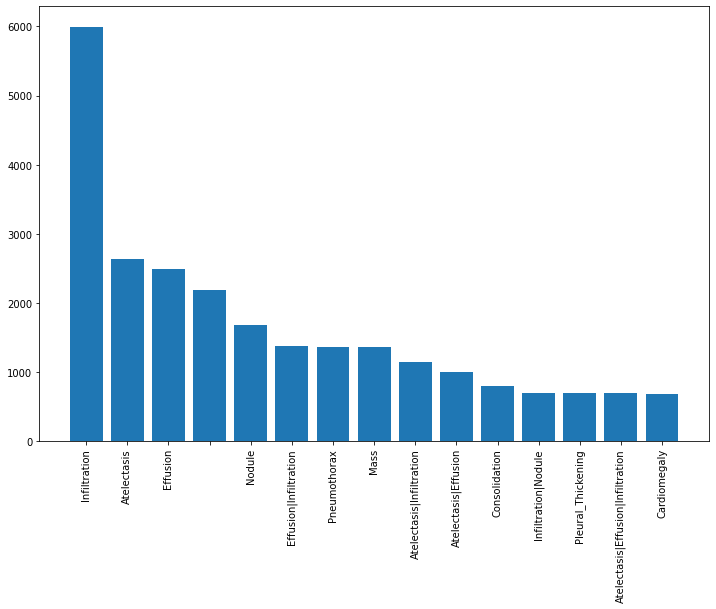

In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

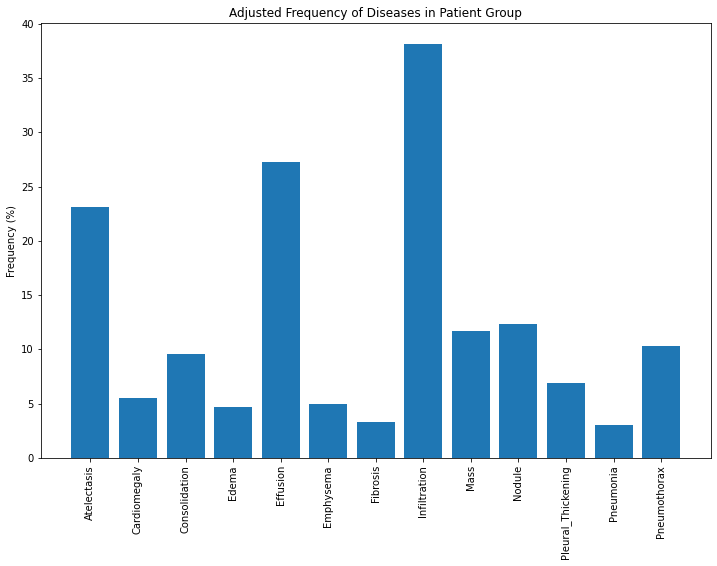

In [ ]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

TypeError: ignored

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

# Check Output
Here we see how many positive examples we have of each category

In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Continued Training
Now we do a much longer training process to see how the results improve

In [ ]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

In [ ]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [ ]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

In [ ]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')